## This notebook contains all of the code required to generate the results of the time series predictions with uncertainty bands using the feed forward neural network architecture.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# First we read in the airline passenger
fileName = "data/international-airline-passengers.csv"
#fileName = "data/wolfer-sunspot-numbers-1770-to-1.csv"
#fileName ='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'
#fileName ='data/total-annual-rainfall-in-inches-.csv'

# Load the data
df = pd.read_csv(fileName, engine='python', skipfooter=3)

# Depending on the dataset that we use, the name of the 'Time' column is different
if(fileName=='data/international-airline-passengers.csv'):
    time_column_name = 'Month'
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    time_column_name='Year'
elif(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    time_column_name='Time'
    df = df[['Time', 'Close']].copy()
elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    time_column_name='Year'

# Convert the time column into appropriate format
df[time_column_name]=pd.to_datetime(df[time_column_name], format='%Y-%m-%d')
df.set_index([time_column_name], inplace=True)


if(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    
    # Split the data set into training and test sets
    train_data = df['2016-01-01 00:00':'2016-05-01 00:00']
    test_data = df['2016-05-01 00:15':'2016-06-30 23:45']
    
    # Convert the training and test set into a flattened array
    time_vals = df[train_data.index[0]:test_data.index[len(test_data)-1]]
    train_data = train_data.values.astype('float32')
    test_data = test_data.values.astype('float32')
    number_of_epochs=10 # The number of epochs for training
    activation_func = 'relu'
    N_uncert_samples = 100 # The number of samples to generate for uncertainty bands
    
    # Extract the raw data, without the dates
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    
    # Convert the training and test set into a flattened array
    time_vals = df[df.index[0]:df.index[len(df)-1]]
    data = df.values
    data = data.astype('float32')
    
    # Now we split the data  into test and train
    split = 71
    train_data =  data[0:split,:]
    test_data = data[split:,:]
    number_of_epochs=300
    activation_func = 'relu'
    N_uncert_samples = 500 # The number of samples to generate for uncertainty bands
    
    
elif(fileName=='data/international-airline-passengers.csv'):
    
    # Convert the training and test set into a flattened array, collect time indices
    # for plotting later
    time_vals = df[df.index[0]:df.index[len(df)-1]]
    data = df.values
    data = data.astype('float32')
    
    # Now we split the data into training and testing
    split = 73
    train_data =  data[0:split,:]
    test_data = data[split:,:]
    number_of_epochs=300
    activation_func = 'relu'
    N_uncert_samples = 500 # The number of samples to generate for uncertainty bands

elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    
    # Convert the training and test set into a flattened array, collect time indices
    # for plotting later
    time_vals = df[df.index[0]:df.index[len(df)-1]]
    data = df.values
    data = data.astype('float32')
    
    # Now we split the data into training and testing sets and apply the data scaling
    split = 70
    train_data =  data[0:split,:]
    test_data = data[split:,:]
    number_of_epochs=300
    activation_func = 'relu'
    N_uncert_samples = 500 # The number of samples to generate for uncertainty bands

# Print the training data
print("train data", train_data.shape)
print('Activation Function: ', activation_func)

def future_data(data,lags=1,future=1):
    '''
    This function, takes in the time series [X_t] and returns the array
    X=[X_{t-1}]
    Y=[X_t]
    '''
    
    X, y = [], []
    for row in range(len(data) - lags - future):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags+future-1, 0])
    return np.array(X), np.array(y)

def scale_array(y_vec):
    '''
    This scales the input data according to the transformation:
    
    F(xi)=(xi-xmin)/(x_max - x_min)
    
    This assures that the data set is in the range [0,1]
    
    '''
    
    # Compute the max and min of the vectors
    ymax = np.max(y_vec)
    ymin = np.min(y_vec)
    
    y_vec_scaled = np.zeros((len(y_vec),1))
    
    # Scale all data points
    for k in range(0,len(y_vec)):
        y_vec_scaled[k][0] = (y_vec[k][0]-ymin)/(ymax-ymin)
    
    return y_vec_scaled,ymin,ymax

def invert_scaling(y_vec_scaled,ymin,ymax):
    '''
    This function inverts the scaling transformation
    '''
    
    y_vec = np.zeros(y_vec_scaled.shape)
        
        
    for k in range(0,len(y_vec_scaled)):
        y_vec[k] = ymin+(ymax-ymin)*y_vec_scaled[k]
    
    return y_vec

# Process the train and test data by scaling it
train_data,train_min,train_max = scale_array(train_data)
test_data,test_min,test_max = scale_array(test_data)

# Here we choose the number of lags for the data set, and how far into the future we are planning to predict
lags=1
future=1

# Process the training and testing data
X_train, y_train = future_data(train_data, lags,future)
X_test, y_test = future_data(test_data, lags,future)

train data (73, 1)
Activation Function:  relu


In [4]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

def build_model(neurons):
    '''
    This function build the Feed Forward Neural Network model with a variable number of nodes.
    '''
    model = Sequential()
    model.add(Dense(neurons, input_dim=lags, activation=activation_func))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Construct the Regressor model
regressor = KerasRegressor(build_fn = build_model,verbose=0)
parameters = {'batch_size': [5,10,20], 
              'epochs': [number_of_epochs],
              'neurons': [4,5,10,15,20]}
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 10)

# Fit the various models using the object defined above
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Now we build and train the optimal model
model = build_model(neurons=best_parameters['neurons'])

# Store the history of loss of the optimal function
history=model.fit(X_train, y_train, epochs=best_parameters['epochs'], batch_size=best_parameters['batch_size'], verbose=0)

/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
# Print out the best parameters of the model
print('Best Parameters:' , best_parameters)
print('Best Neg mean squared error: ', best_accuracy)


# Summarize the Feed forward neural network model
model.summary()

Best Parameters: {'batch_size': 10, 'neurons': 20, 'epochs': 300}
Best Neg mean squared error:  -0.0090695360809388
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_303 (Dense)            (None, 20)                40        
_________________________________________________________________
dense_304 (Dense)            (None, 1)                 21        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss'])


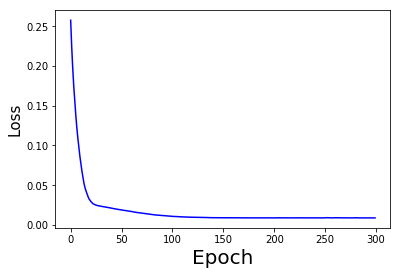

In [6]:
#--------------------------------------------------------------------
# Here we plot the loss of the FFNN model with the number of Epochs in the training
#--------------------------------------------------------------------

print(history.history.keys())


if(fileName=='data/international-airline-passengers.csv'):
    loss_label = 'figures/Loss_airline.pdf'
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    loss_label = 'figures/Loss_sunspot.pdf'
elif(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    loss_label = 'figures/Loss_EURUSD.pdf'
elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    loss_label = 'figures/Loss_rainfall.pdf'

plt.plot()
plt.plot(history.history['loss'],color='b')
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epoch',fontsize=20)
plt.savefig(loss_label,bboxes='tight')
plt.show()

Estimated Sigma:  0.04547811545890527 0.060318418322231684
-------------------------------------
MSE:  573.0045918671749
RMSE:  23.93751432098109
-------------------------------------


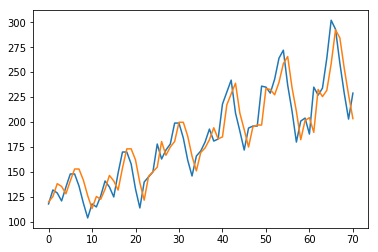

In [7]:
# The number of random samples that we will use to generate uncertainty bands
uncertainty_samples = N_uncert_samples

# We generate predictions on the training and test data sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# We compute the residuals of the fitted model to the training set
residuals = np.abs(y_test.reshape(-1, 1) - test_predict.reshape(-1, 1))

# Here we estimate the average residual values and stdev.
sigma = 0.5*np.mean(residuals)
std_sigma =  0.5*np.std(residuals)
print("Estimated Sigma: ", sigma, np.std(residuals))

# Here we perturb the test set and generate predictions based on pertrubed data, to generate uncertainty bands
test_predictions = []
for k in range(0,uncertainty_samples):
    test_predict = model.predict(X_test)+np.random.normal(sigma, std_sigma, test_predict.shape)
    test_predictions.append(test_predict)

test_predictions = np.asarray(test_predictions)
y = test_predict.flatten()[future:]

def return_min_max_prediction(test_predictions,i):
    '''
    This function will return the maxium and minimum values of the sampled predictions
    in order to generate the uncertainty bands
    '''
    
    y_vec = [ test_predictions[k][i][0] for k in range(0,test_predictions.shape[0])]
    
    ymin = np.min(y_vec)
    ymax = np.max(y_vec)
    
    return ymin,ymax

# Compute the upper and lower bands of the sampled predictions
y_min = np.asarray([return_min_max_prediction(test_predictions,i)[0] for i in range(0,len(y))])
y_max = np.asarray([return_min_max_prediction(test_predictions,i)[1] for i in range(0,len(y))])
x = np.arange(-future,len(y_min)-future)


# Unscale all of the data, to produce data in the original set
y_test = invert_scaling(y_test,test_min,test_max)
y_min = invert_scaling(y_min,test_min,test_max)
y_max = invert_scaling(y_max,test_min,test_max)
y = invert_scaling(y,test_min,test_max)


# Compute the root mean squared error
mse = ((y_test[:-1].reshape(-1, 1) - y.reshape(-1, 1)) ** 2).mean()


print('-------------------------------------')
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
print('-------------------------------------')


#============================================================================================
# Unscale data
#test_predictions = scaler.inverse_transform(test_predictions)
y_train = invert_scaling(y_train,train_min,train_max)
train_predict = invert_scaling(train_predict,train_min,train_max)


x_test = range(len(y_train),len(y_train)+len(y_test))
x = range(len(y_train),len(y_train)+len(y))

plt.plot(y_train)
plt.plot(train_predict)

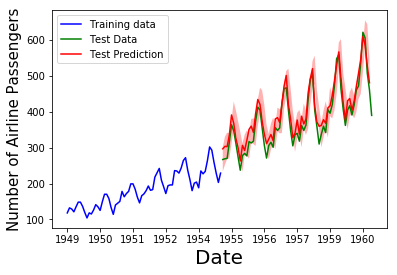

In [8]:

if(fileName=='data/international-airline-passengers.csv'):
    time_steps = 15
    time_format= "%Y"
    y_label = 'Number of Airline Passengers'
    output_name = 'figures/Airline_Passengers_NN.pdf'
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    time_steps = 10
    time_format= "%Y"
    y_label = 'Number of Sunspots'
    output_name = 'figures/Sunspot_Forecast_NN.pdf'
elif(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    time_format= "%m-%H:%M"
    time_steps = 2800
    y_label = 'Exchange Rate EUR/USD'
    output_name = 'figures/EURO_USD_exchange_rate_NN.pdf'
elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    time_format= "%Y"
    time_steps = 15
    y_label = 'Annual Rainfall [Inches] London'
    output_name = 'figures/Annual_Rainfall_NN.pdf'

vals= range(0,len(y_train)+len(y_test),time_steps)
labels = [time_vals.index[k].strftime(time_format) for k in vals]

# Now we plot the predictions with the uncertainty bands 
plt.xticks(vals, labels)
plt.ylabel(y_label,fontsize=15)
plt.xlabel('Date',fontsize=20)
plt.plot(y_train, label='Training data',color='b');
plt.plot(x_test,y_test.reshape(-1, 1), label='Test Data', color='g')
plt.plot(x,y, label='Test Prediction', color='red')
plt.fill_between(x, y_min, y_max, facecolor='red', interpolate=True,alpha=0.3)
plt.legend(loc=2)
plt.savefig(output_name,bboxes='tight')
plt.show()